### Graphing post CBR fixes

In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import FormatStrFormatter

In [6]:
import json
import os

In [7]:
# JSON file containing the results for this simulation run
json_file = "/Users/brianmccarthy/git_repos/results-analysis/configs/cv2x.json"

In [8]:
with open(json_file) as results_json:
    config = json.load(results_json)
    config = config["cv2x"]

In [9]:
# Markers to use for this run
markers = [".", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h",
           "H", "+", "x", "X", "D", "d", "|", "_", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [10]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning.
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity * width + 1, width):
        bins.append((low, low + width))
    return bins

In [11]:
def bin_fields(df, fields, bin_width=10, bin_quantity=49):
    """
    Bins multiple dfs into a single dictionary that can be used as an average for multiple fields across multiple
    runs
    :param df: dataframe to bin
    :param fields: fields to be binned.
    :param bin_width: width of each bin
    :param bin_quantity: total number of bins
    :return:
    """
    bins = create_bins(lower_bound=0, width=bin_width, quantity=bin_quantity)
    distances = []
    overall_fields = {}
    for interval in bins:
        upper_b = interval[1]
        distances.append(upper_b)

    for field in fields:
        overall_fields[field] = []

    overall_fields["distance"] = distances

    distance_col = config["results"]["distance"]

    for i in range(len(bins)):
        lower_b = bins[i][0]
        upper_b = bins[i][1]
        fields_temp = df[(df[distance_col] >= lower_b) & (df[distance_col] < upper_b)]
        for field in fields:
            if i < len(overall_fields[field]):
                overall_fields[field][i] = (fields_temp[field].mean() + overall_fields[field][i]) / 2
            else:
                overall_fields[field].append(fields_temp[field].mean())

    return overall_fields

In [12]:
def pdr_dist(pdrs, distances, labels, plot_name, show=True, store=True):
    fig, ax = plt.subplots()

    for i in range(len(pdrs)):
        ax.plot(distances, pdrs[i], label=labels[i])

    ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate (PDR) %')
    ax.legend(loc='lower left')
    ax.tick_params(direction='in')
    
    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=.1))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.suptitle(plot_name, fontsize=12)
    
    if show:
        fig.show()
        
    if store:
        fig.savefig("{}.png".format(plot_name), dpi=300)

### Setup for graphing

1. First open all the folders
2. Read all the results in DF
3. Bin all the fields we are interested in.
4. Make a dictionary of each config bins together.

In [13]:
distances = create_bins(0, 10, 49)

In [14]:
for i in range(len(distances)):
    distances[i] = distances[i][1]

In [46]:
def read_folder_content(folder_path):
    pdr = []
    tbSent = 0
    sciSent = 0
    
    fileCount = 0
    for file in os.listdir(folder_path):
        if "csv" in file:
            fileCount += 1
            print("File: {} being parsed".format(file))
            df = pd.read_csv(os.path.join(folder_path, file))
            df = df[df["Time"] > 502]
            binned_fields = bin_fields(df, ["tbDecoded"])
            for i in range(len(binned_fields["tbDecoded"])):
                if i < len(pdr):
                    pdr[i] = (binned_fields["tbDecoded"][i] + pdr[i]) / 2
                else:
                    pdr.append(binned_fields["tbDecoded"][i])
                    
            tbSent += df["tbSent"].count()
            sciSent += df["sciSent"].count()
            
            print("Total TBs Sent: {}, Total this file: {}".format(tbSent, df["tbSent"].count()))
            print("Total SCIs Sent: {}, Total this file: {}".format(sciSent, df["sciSent"].count()))
            
    tbSent = tbSent/fileCount
    sciSent = sciSent/fileCount
    return pdr, tbSent, sciSent

In [42]:
results_folder = "/Users/brianmccarthy/git_repos/results-analysis/data/raw_data/cv2x"

In [31]:
results_dict = {}

for folder in os.listdir(results_folder):
    if ".DS" not in folder:
        print("="*50)
        print("Folder: {} being parsed".format(folder))
        print("="*50)
        results_dict[folder] = {"pdr": []}
        pdr, tbSent, sciSent = read_folder_content(os.path.join(results_folder, folder))
        results_dict[folder]["pdr"] = pdr
        results_dict[folder]["tbSent"] = tbSent
        results_dict[folder]["sciSent"] = sciSent

Folder: Prob-0.2 being parsed
File: run-6-2019-10-21-10:55:37.csv being parsed
File: run-14-2019-10-21-10:55:37.csv being parsed
File: run-9-2019-10-21-10:55:37.csv being parsed
File: run-25-2019-10-21-10:55:37.csv being parsed
File: run-21-2019-10-21-10:55:37.csv being parsed
File: run-10-2019-10-21-10:55:37.csv being parsed
File: run-2-2019-10-21-10:55:37.csv being parsed
File: run-22-2019-10-21-10:55:37.csv being parsed
File: run-1-2019-10-21-10:55:37.csv being parsed
File: run-13-2019-10-21-10:55:37.csv being parsed
File: run-17-2019-10-21-10:55:37.csv being parsed
File: run-5-2019-10-21-10:55:37.csv being parsed
File: run-29-2019-10-21-10:55:37.csv being parsed
File: run-26-2019-10-21-10:55:37.csv being parsed
File: run-18-2019-10-21-10:55:37.csv being parsed
File: run-3-2019-10-21-10:55:37.csv being parsed
File: run-11-2019-10-21-10:55:37.csv being parsed
File: run-20-2019-10-21-10:55:37.csv being parsed
File: run-24-2019-10-21-10:55:37.csv being parsed
File: run-8-2019-10-21-10:

File: run-6-2019-10-20-10:58:34.csv being parsed
File: run-14-2019-10-20-10:58:34.csv being parsed
File: run-25-2019-10-20-10:58:34.csv being parsed
File: run-9-2019-10-20-10:58:34.csv being parsed
File: run-29-2019-10-20-10:58:34.csv being parsed
File: run-17-2019-10-20-10:58:34.csv being parsed
File: run-5-2019-10-20-10:58:34.csv being parsed
File: run-18-2019-10-20-10:58:34.csv being parsed
File: run-26-2019-10-20-10:58:34.csv being parsed
File: run-22-2019-10-20-10:58:34.csv being parsed
File: run-1-2019-10-20-10:58:34.csv being parsed
File: run-13-2019-10-20-10:58:34.csv being parsed
Folder: Prob-0.6 being parsed
File: run-11-2019-10-21-16_08_24.csv being parsed
File: run-3-2019-10-21-16_08_24.csv being parsed
File: run-20-2019-10-21-16_08_24.csv being parsed
File: run-8-2019-10-21-16_08_24.csv being parsed
File: run-24-2019-10-21-16_08_24.csv being parsed
File: run-7-2019-10-21-16_08_24.csv being parsed
File: run-15-2019-10-21-16_08_24.csv being parsed
File: run-27-2019-10-21-16_

File: run-25-2019-10-21-16_32_41.csv being parsed
File: run-14-2019-10-21-16_32_41.csv being parsed


In [32]:
prob_pdrs = []
prob_pdrs.append(results_dict["Prob-0.0"]["pdr"])
prob_pdrs.append(results_dict["Prob-0.2"]["pdr"])
prob_pdrs.append(results_dict["Prob-0.4"]["pdr"])
prob_pdrs.append(results_dict["Prob-0.6"]["pdr"])
prob_pdrs.append(results_dict["Prob-0.8"]["pdr"])
prob_labels = ["Prob-0.0", "Prob-0.2", "Prob-0.4", "Prob-0.6", "Prob-0.8"]

slow_fast_pdrs = []
slow_fast_pdrs.append(results_dict["highway-slow"]["pdr"])
slow_fast_pdrs.append(results_dict["Prob-0.4"]["pdr"])
slow_fast_labels = ["Highway Slow", "Highway Fast"]

/Users/brianmccarthy/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


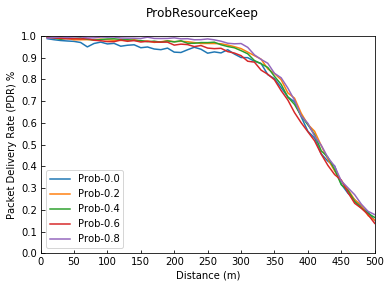

In [34]:
pdr_dist(prob_pdrs, distances, prob_labels, "ProbResourceKeep")

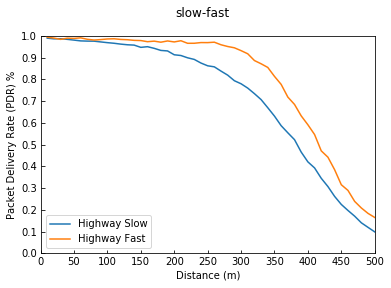

In [35]:
pdr_dist(slow_fast_pdrs, distances, slow_fast_labels, "slow-fast")

### Non-periodic Setup

In [36]:
non_periodic_dir = "/Users/brianmccarthy/git_repos/results-analysis/data/raw_data/cv2x/non-periodic"

In [50]:
df = pd.read_csv(non_periodic_dir + "/run-1-2019-10-20-10:58:34.csv")

In [56]:
len(df["NodeID"].unique())

174

In [47]:
results_dict = {}

for folder in os.listdir(results_folder):
    if "non-periodic" in folder:
        print("="*50)
        print("Folder: {} being parsed".format(folder))
        print("="*50)
        results_dict[folder] = {"pdr": []}
        pdr, tbSent, sciSent = read_folder_content(os.path.join(results_folder, folder))
        results_dict[folder]["pdr"] = pdr
        results_dict[folder]["tbSent"] = tbSent
        results_dict[folder]["sciSent"] = sciSent

Folder: non-periodic being parsed
File: run-8-2019-10-20-10:58:34.csv being parsed
Total TBs Sent: 5984, Total this file: 5984
Total SCIs Sent: 9289, Total this file: 9289
File: run-15-2019-10-20-10:58:34.csv being parsed
Total TBs Sent: 11968, Total this file: 5984
Total SCIs Sent: 18578, Total this file: 9289
File: run-7-2019-10-20-10:58:34.csv being parsed
Total TBs Sent: 17952, Total this file: 5984
Total SCIs Sent: 27867, Total this file: 9289
File: run-3-2019-10-20-10:58:34.csv being parsed
Total TBs Sent: 23936, Total this file: 5984
Total SCIs Sent: 37156, Total this file: 9289
File: run-11-2019-10-20-10:58:34.csv being parsed
Total TBs Sent: 29920, Total this file: 5984
Total SCIs Sent: 46445, Total this file: 9289
File: run-20-2019-10-20-10:58:34.csv being parsed
Total TBs Sent: 35904, Total this file: 5984
Total SCIs Sent: 55734, Total this file: 9289
File: run-12-2019-10-20-10:58:34.csv being parsed
Total TBs Sent: 41888, Total this file: 5984
Total SCIs Sent: 65023, Total 

In [37]:
non_periodic_results = results_dict["non-periodic"]

In [48]:
non_periodic_results["tbSent"]

5984

In [49]:
non_periodic_results["sciSent"]

9289